In [2]:
#!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [3]:
#!pip install ipdb
#!pip install torch torch-geometric
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipdb



from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [53]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    #pca = PCA(n_components=pca_components)
    #reduced_features = pca.fit_transform(features)  
    #x = torch.tensor(reduced_features, dtype=torch.float32) 
    x = torch.stack(features) 

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)

def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)
   


class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 2):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = loss_fn(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, stage_labels=None, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all, display_labels=stage_labels)
    return logits_all, pred_all, results, disp

def calc_metrics(actual_labels, pred_vals, display_labels=None, print_results=True):
    results = {
        'accuracy': accuracy_score(actual_labels, pred_vals),
        'f1': f1_score(actual_labels, pred_vals, average='macro'),
        'precision': precision_score(actual_labels, pred_vals, average='macro'),
        'recall': recall_score(actual_labels, pred_vals, average='macro')
    }

    cm = confusion_matrix(actual_labels, pred_vals)

    # Get only the unique classes present in the actual predictions
    unique_classes = np.unique(np.concatenate([actual_labels, pred_vals]))  
    if display_labels is None:
        display_labels = [str(label) for label in unique_classes]  # Ensure matching labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    if print_results:
        for metric, value in results.items():
            print(f'{metric}: {value:.3f}')
        disp.plot()
        plt.show()

    return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = features.shape[1]
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

        train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
        train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
        dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
----------- Task: CTD -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.75268
Epoch 50, Loss: 0.26197
Epoch 100, Loss: 0.00291
Epoch 150, Loss: 0.00035
Epoch 200, Loss: 0.00020
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.880
f1: 0.468
precision: 0.458
recall: 0.478


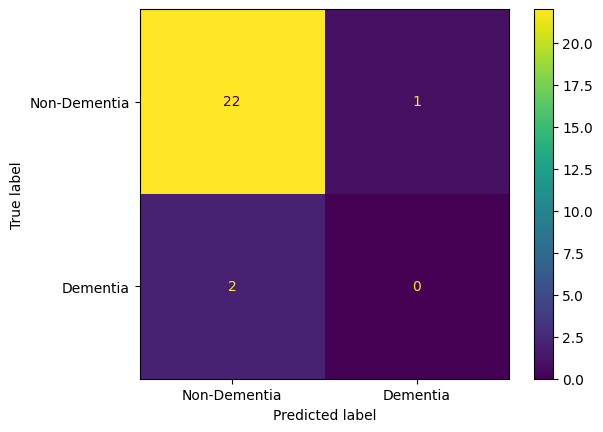

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.844
f1: 0.458
precision: 0.435
recall: 0.482


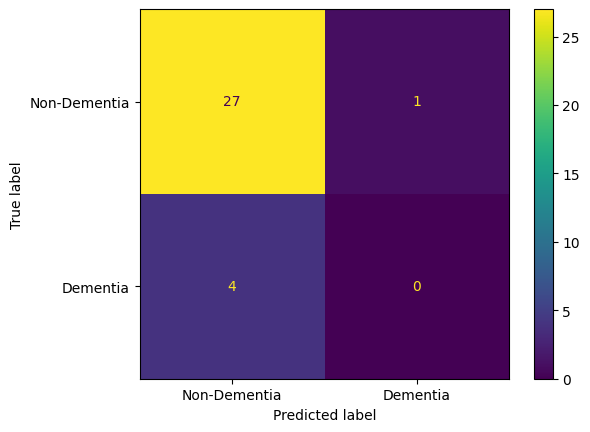

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.70697
Epoch 50, Loss: 0.26226
Epoch 100, Loss: 0.00354
Epoch 150, Loss: 0.00097
Epoch 200, Loss: 0.00050
Validating Stage 2 model on ensemble training set...
Setting batch size to  22
accuracy: 0.409
f1: 0.398
precision: 0.400
recall: 0.397


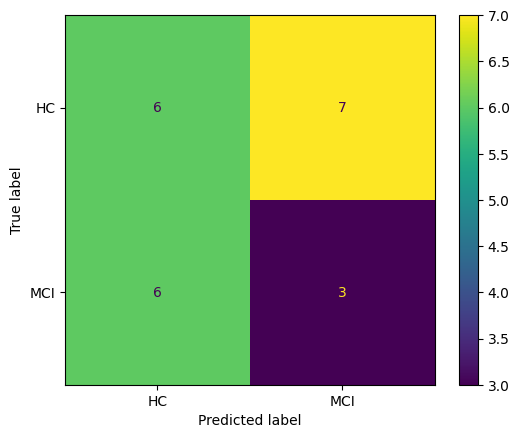

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.556
f1: 0.550
precision: 0.552
recall: 0.554


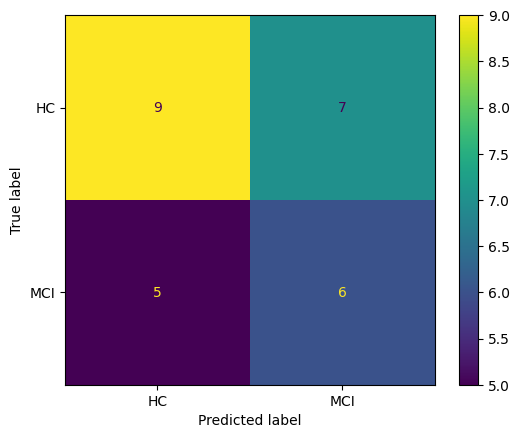

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.46      0.48        13
         MCI       0.30      0.30      0.30        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.39      0.36      0.38        25
   macro avg       0.27      0.25      0.26        25
weighted avg       0.38      0.36      0.37        25

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.64      0.53      0.58        17
         MCI       0.46      0.55      0.50        11
    Dementia       0.00      0.00      0.00         4

   micro avg       0.54      0.47      0.50        32
   macro avg       0.37      0.36      0.36        32
weighted avg       0.50      0.47      0.48        32

----------- Task: SFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.77813


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


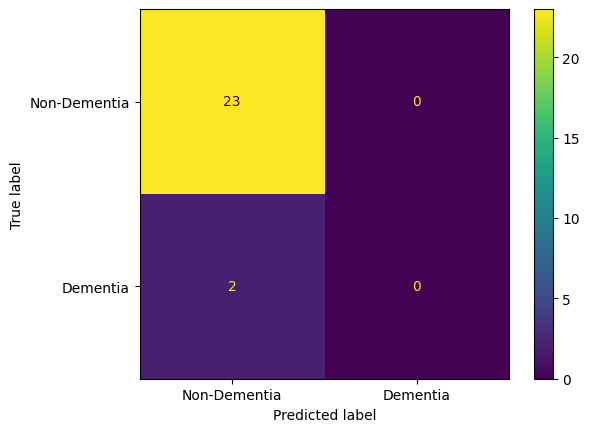

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.781
f1: 0.439
precision: 0.431
recall: 0.446


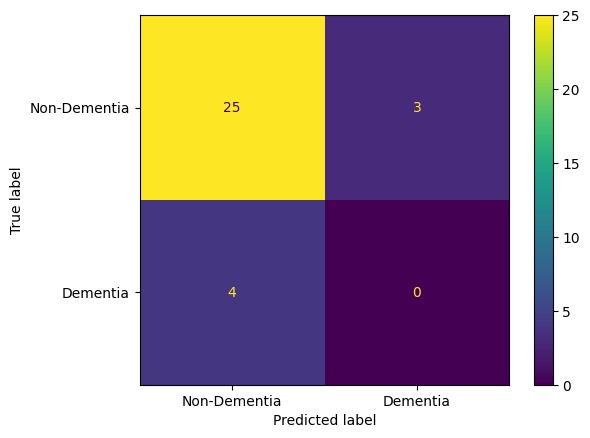

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.71902
Epoch 50, Loss: 0.07631
Epoch 100, Loss: 0.00103
Epoch 150, Loss: 0.00050
Epoch 200, Loss: 0.00032
Validating Stage 2 model on ensemble training set...
Setting batch size to  23
accuracy: 0.478
f1: 0.452
precision: 0.454
recall: 0.458


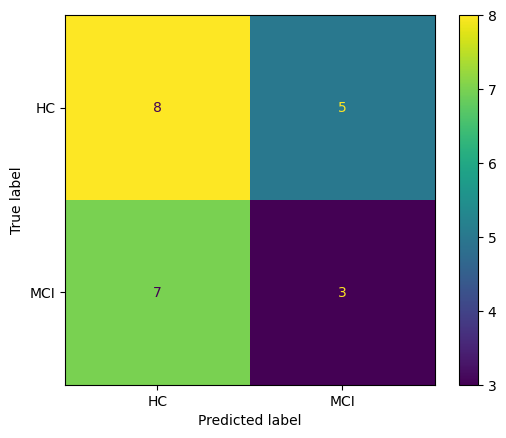

Validating Stage 2 model on meta model dev set...
Setting batch size to  25
accuracy: 0.680
f1: 0.632
precision: 0.647
recall: 0.628


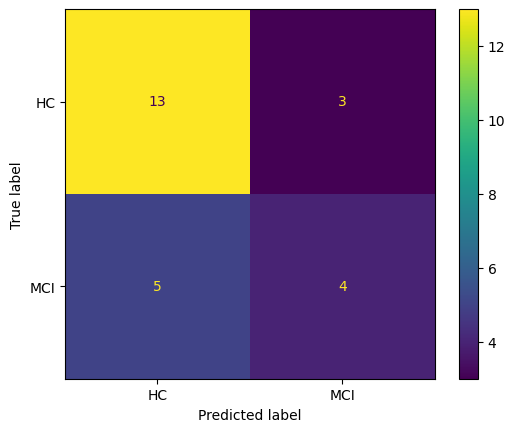

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.53      0.62      0.57        13
         MCI       0.38      0.30      0.33        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.48      0.44      0.46        25
   macro avg       0.30      0.31      0.30        25
weighted avg       0.43      0.44      0.43        25

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.72      0.76      0.74        17
         MCI       0.57      0.36      0.44        11
    Dementia       0.00      0.00      0.00         4

   micro avg       0.61      0.53      0.57        32
   macro avg       0.43      0.38      0.40        32
weighted avg       0.58      0.53      0.55        32

----------- Task: PFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.72743


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 50, Loss: 0.02403
Epoch 100, Loss: 0.00013
Epoch 150, Loss: 0.00008
Epoch 200, Loss: 0.00006
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.880
f1: 0.468
precision: 0.458
recall: 0.478


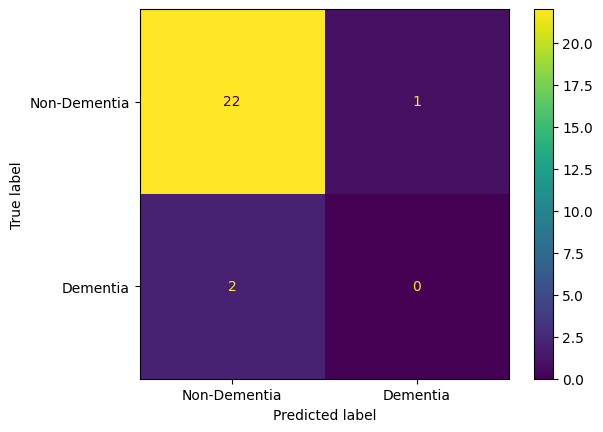

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.875
f1: 0.632
precision: 0.700
recall: 0.607


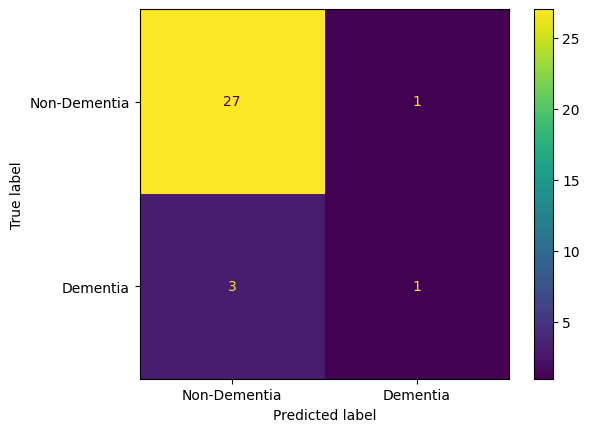

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.69482
Epoch 50, Loss: 0.00083
Epoch 100, Loss: 0.00009
Epoch 150, Loss: 0.00006
Epoch 200, Loss: 0.00004
Validating Stage 2 model on ensemble training set...
Setting batch size to  22
accuracy: 0.455
f1: 0.450
precision: 0.450
recall: 0.450


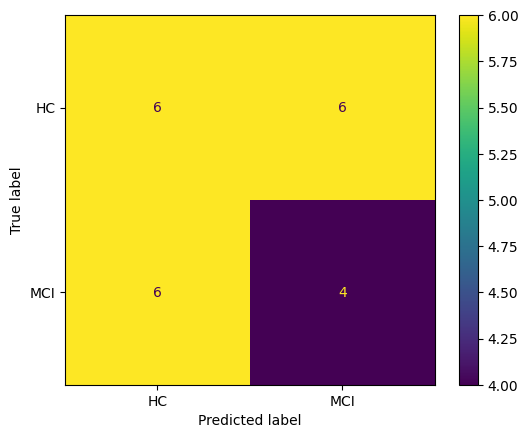

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.630
f1: 0.616
precision: 0.617
recall: 0.624


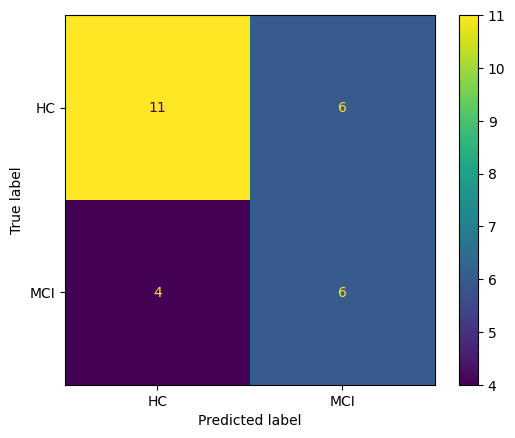

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.46      0.48        13
         MCI       0.40      0.40      0.40        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.43      0.40      0.42        25
   macro avg       0.30      0.29      0.29        25
weighted avg       0.42      0.40      0.41        25

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.73      0.65      0.69        17
         MCI       0.50      0.55      0.52        11
    Dementia       0.50      0.25      0.33         4

   micro avg       0.62      0.56      0.59        32
   macro avg       0.58      0.48      0.51        32
weighted avg       0.62      0.56      0.59        32

Fold 1:

        train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}),
        train set for meta model: 

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


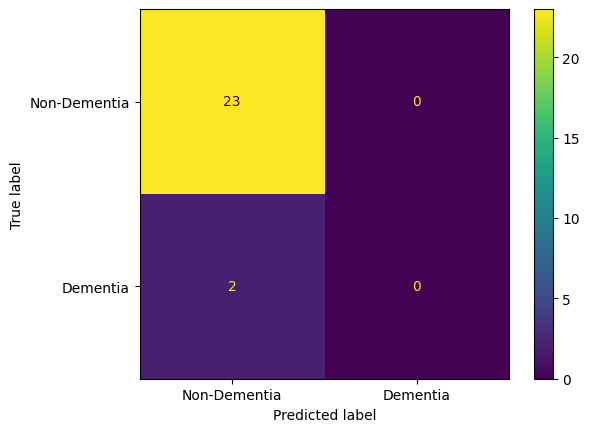

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.750
f1: 0.429
precision: 0.429
recall: 0.429


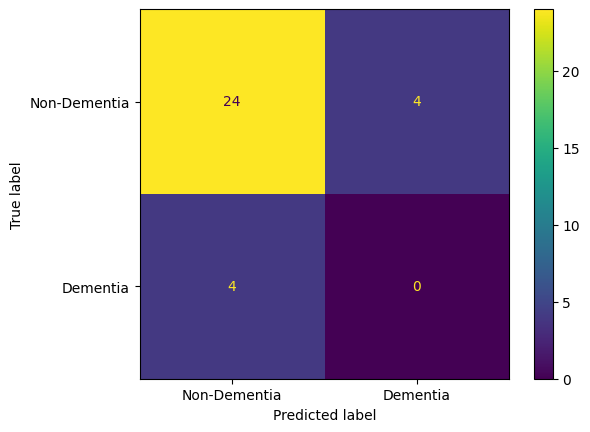

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.70579
Epoch 50, Loss: 0.29110
Epoch 100, Loss: 0.00820
Epoch 150, Loss: 0.00140
Epoch 200, Loss: 0.00068
Validating Stage 2 model on ensemble training set...
Setting batch size to  23
accuracy: 0.652
f1: 0.635
precision: 0.646
recall: 0.635


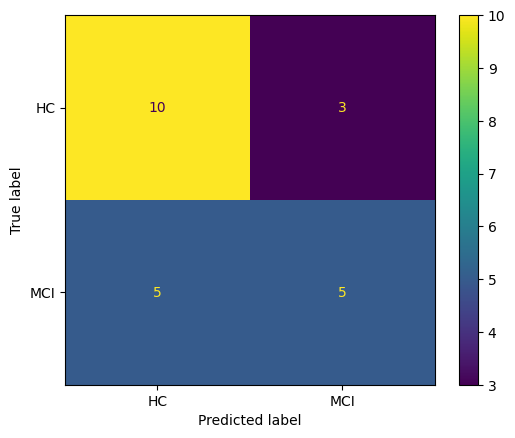

Validating Stage 2 model on meta model dev set...
Setting batch size to  24
accuracy: 0.500
f1: 0.438
precision: 0.444
recall: 0.437


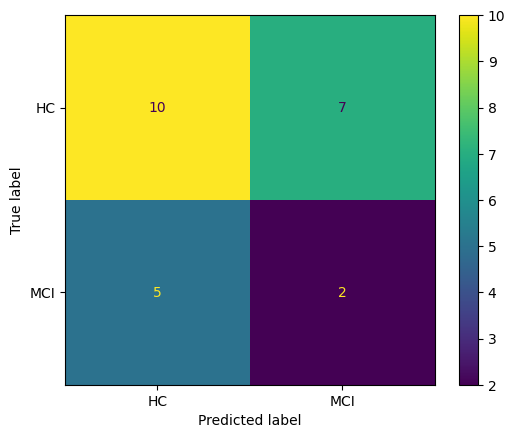

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.77      0.71        13
         MCI       0.62      0.50      0.56        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.65      0.60      0.62        25
   macro avg       0.43      0.42      0.42        25
weighted avg       0.60      0.60      0.59        25

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.56      0.61        18
         MCI       0.22      0.20      0.21        10
    Dementia       0.00      0.00      0.00         4

   micro avg       0.43      0.38      0.40        32
   macro avg       0.30      0.25      0.27        32
weighted avg       0.44      0.38      0.41        32

----------- Task: SFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.77776


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 50, Loss: 0.11792
Epoch 100, Loss: 0.00042
Epoch 150, Loss: 0.00019
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.800
f1: 0.444
precision: 0.455
recall: 0.435


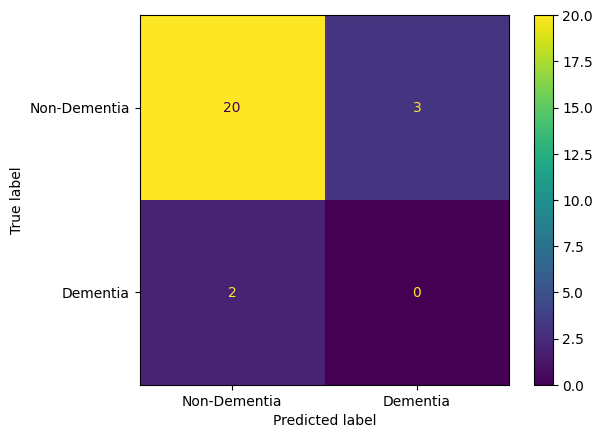

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.875
f1: 0.467
precision: 0.438
recall: 0.500


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


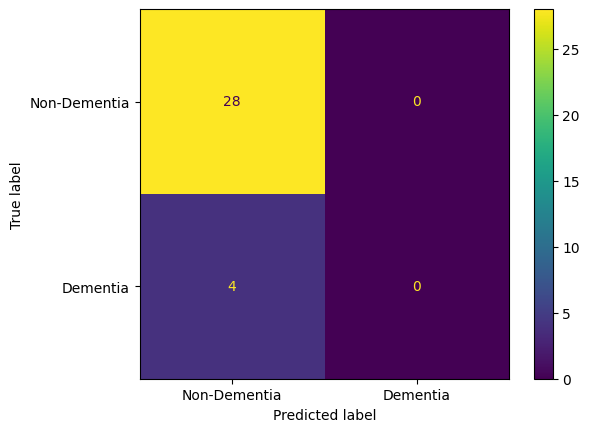

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.70747
Epoch 50, Loss: 0.10463
Epoch 100, Loss: 0.00062
Epoch 150, Loss: 0.00031
Epoch 200, Loss: 0.00020
Validating Stage 2 model on ensemble training set...
Setting batch size to  20
accuracy: 0.550
f1: 0.540
precision: 0.540
recall: 0.542


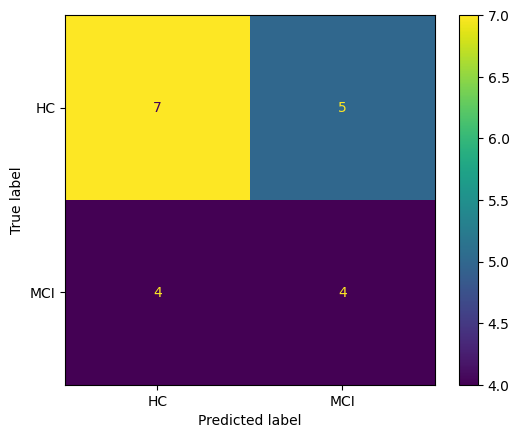

Validating Stage 2 model on meta model dev set...
Setting batch size to  28
accuracy: 0.500
f1: 0.456
precision: 0.456
recall: 0.456


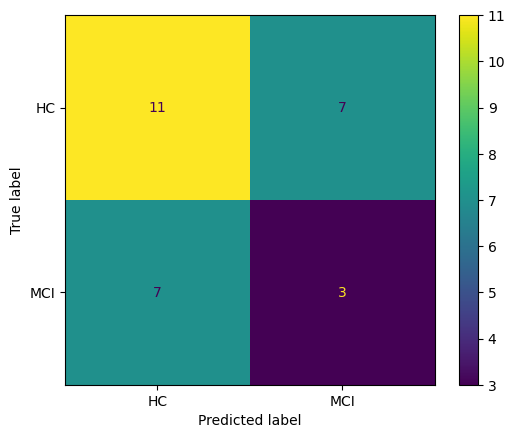

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.64      0.54      0.58        13
         MCI       0.44      0.40      0.42        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.48      0.44      0.46        25
   macro avg       0.36      0.31      0.33        25
weighted avg       0.51      0.44      0.47        25

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.61      0.61      0.61        18
         MCI       0.30      0.30      0.30        10
    Dementia       0.00      0.00      0.00         4

   micro avg       0.50      0.44      0.47        32
   macro avg       0.30      0.30      0.30        32
weighted avg       0.44      0.44      0.44        32

----------- Task: PFT -----------
Training base model for Dementia Classification...
Setting batch size to  100


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0, Loss: 0.72735
Epoch 50, Loss: 0.00471
Epoch 100, Loss: 0.00007
Epoch 150, Loss: 0.00005
Epoch 200, Loss: 0.00004
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.880
f1: 0.468
precision: 0.458
recall: 0.478


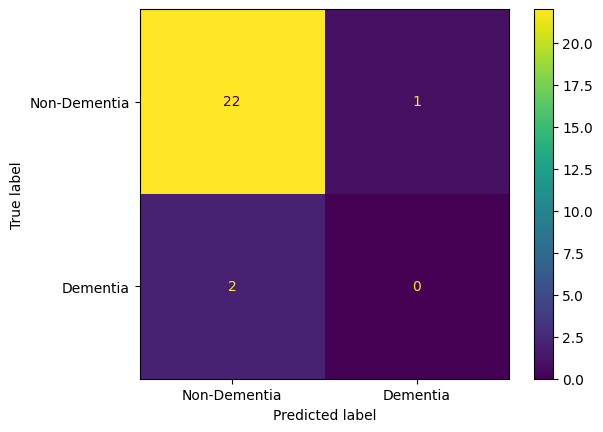

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.812
f1: 0.571
precision: 0.571
recall: 0.571


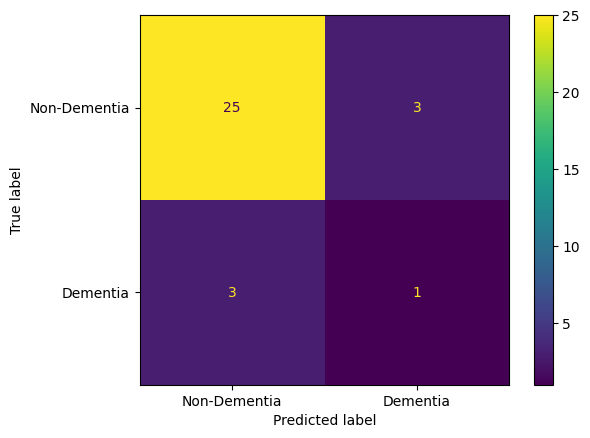

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.69073
Epoch 50, Loss: 0.00103
Epoch 100, Loss: 0.00011
Epoch 150, Loss: 0.00007
Epoch 200, Loss: 0.00006
Validating Stage 2 model on ensemble training set...
Setting batch size to  22
accuracy: 0.318
f1: 0.317
precision: 0.325
recall: 0.321


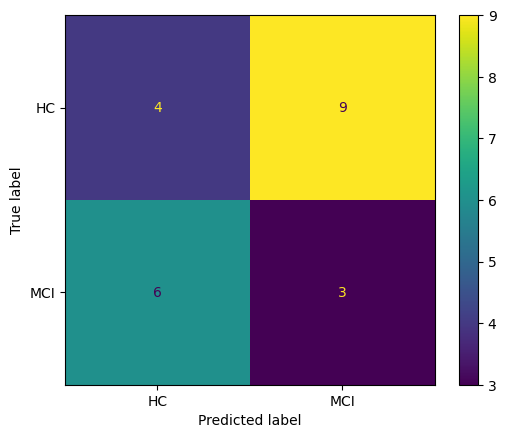

Validating Stage 2 model on meta model dev set...
Setting batch size to  25
accuracy: 0.600
f1: 0.583
precision: 0.593
recall: 0.607


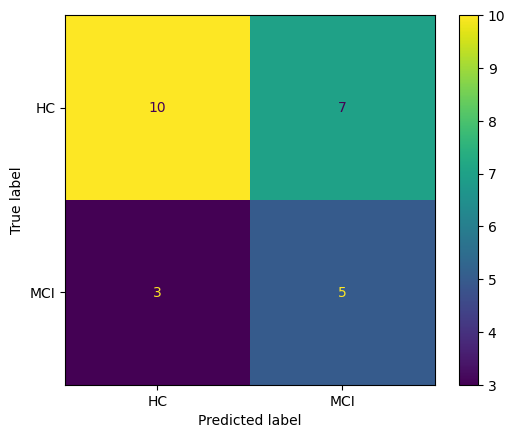

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.40      0.31      0.35        13
         MCI       0.25      0.30      0.27        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.30      0.28      0.29        25
   macro avg       0.22      0.20      0.21        25
weighted avg       0.31      0.28      0.29        25

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.77      0.56      0.65        18
         MCI       0.42      0.50      0.45        10
    Dementia       0.25      0.25      0.25         4

   micro avg       0.55      0.50      0.52        32
   macro avg       0.48      0.44      0.45        32
weighted avg       0.59      0.50      0.54        32

Fold 2:

        train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
        train set for meta model: 

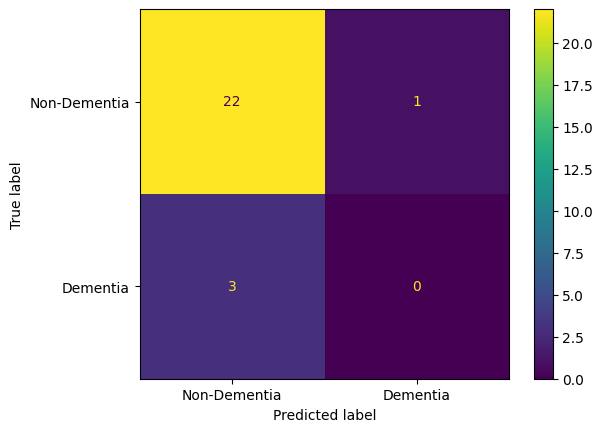

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.871
f1: 0.466
precision: 0.466
recall: 0.466


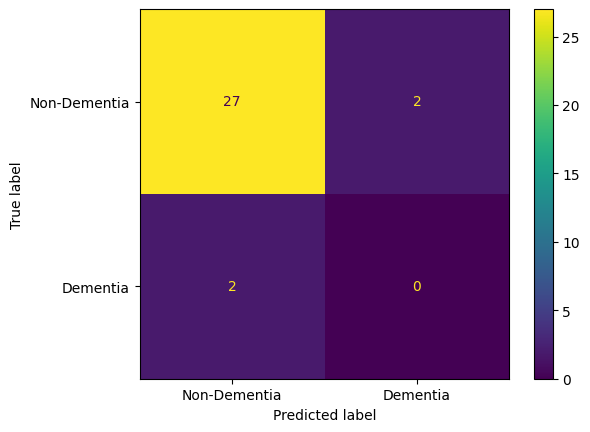

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  89
Epoch 0, Loss: 0.70774
Epoch 50, Loss: 0.33009
Epoch 100, Loss: 0.00332
Epoch 150, Loss: 0.00089
Epoch 200, Loss: 0.00050
Validating Stage 2 model on ensemble training set...
Setting batch size to  22
accuracy: 0.409
f1: 0.398
precision: 0.400
recall: 0.397


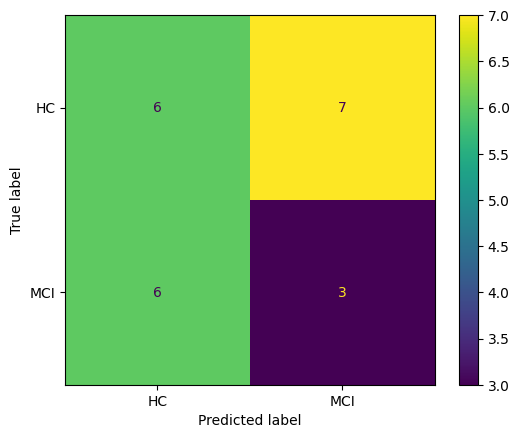

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.593
f1: 0.593
precision: 0.600
recall: 0.600


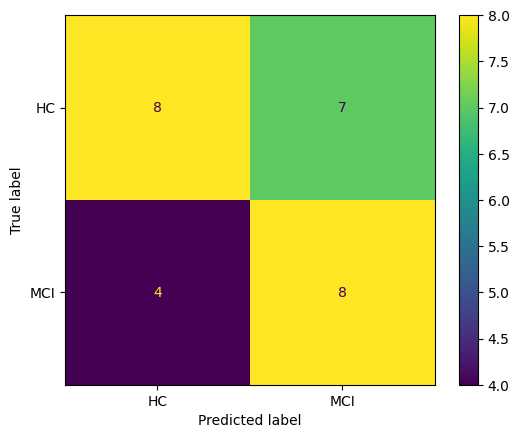

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.43      0.46        14
         MCI       0.30      0.33      0.32         9
    Dementia       0.00      0.00      0.00         3

   micro avg       0.39      0.35      0.37        26
   macro avg       0.27      0.25      0.26        26
weighted avg       0.37      0.35      0.36        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.50      0.57        16
         MCI       0.53      0.62      0.57        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.55      0.52      0.53        31
   macro avg       0.40      0.37      0.38        31
weighted avg       0.57      0.52      0.53        31

----------- Task: SFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.77105


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


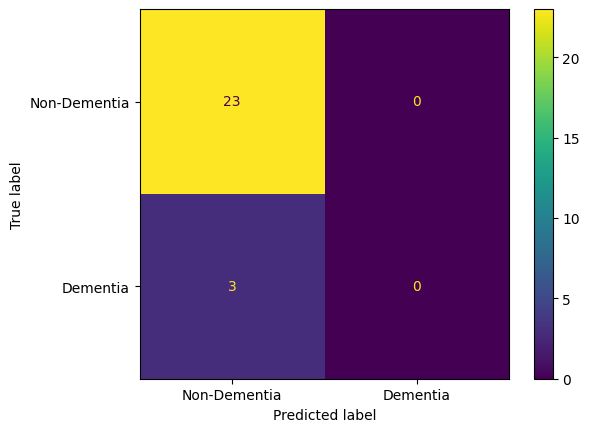

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.871
f1: 0.631
precision: 0.606
recall: 0.698


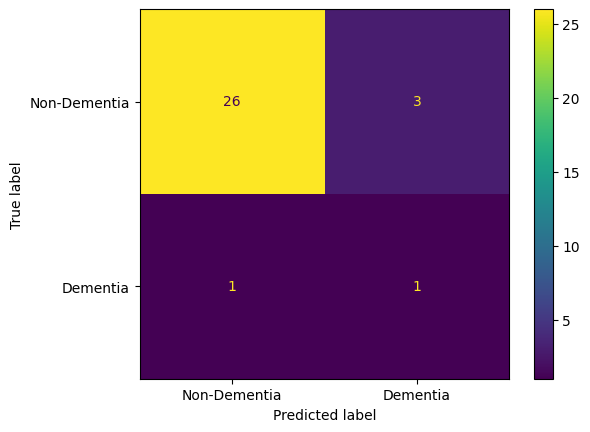

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  89
Epoch 0, Loss: 0.71217
Epoch 50, Loss: 0.06219
Epoch 100, Loss: 0.00072
Epoch 150, Loss: 0.00038
Epoch 200, Loss: 0.00025
Validating Stage 2 model on ensemble training set...
Setting batch size to  23
accuracy: 0.565
f1: 0.558
precision: 0.561
recall: 0.563


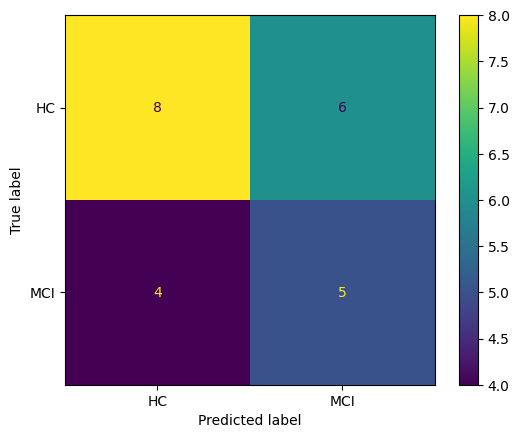

Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.577
f1: 0.519
precision: 0.550
recall: 0.536


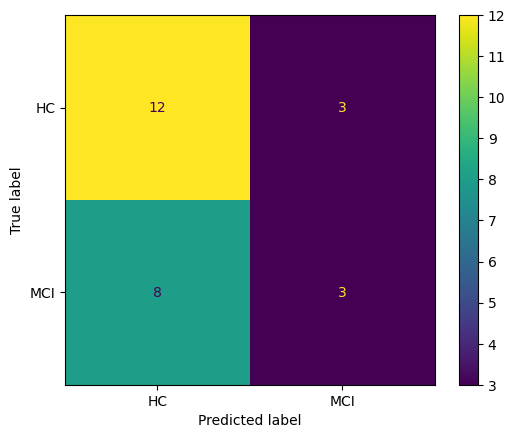

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.57      0.62        14
         MCI       0.45      0.56      0.50         9
    Dementia       0.00      0.00      0.00         3

   micro avg       0.57      0.50      0.53        26
   macro avg       0.37      0.38      0.37        26
weighted avg       0.52      0.50      0.50        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.60      0.75      0.67        16
         MCI       0.50      0.23      0.32        13
    Dementia       0.25      0.50      0.33         2

   micro avg       0.53      0.52      0.52        31
   macro avg       0.45      0.49      0.44        31
weighted avg       0.54      0.52      0.50        31

----------- Task: PFT -----------


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.72952
Epoch 50, Loss: 0.02064
Epoch 100, Loss: 0.00012
Epoch 150, Loss: 0.00008
Epoch 200, Loss: 0.00006
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.808
f1: 0.447
precision: 0.438
recall: 0.457


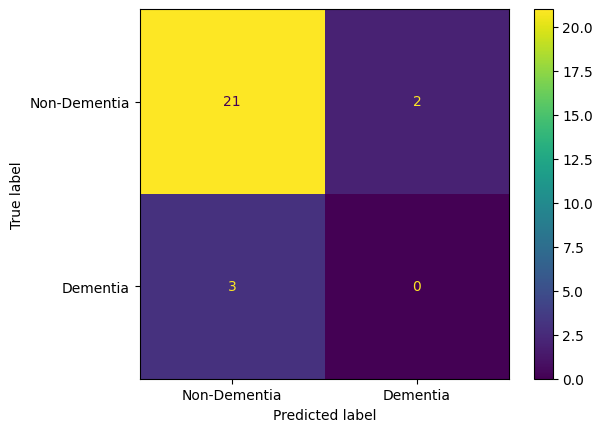

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.806
f1: 0.446
precision: 0.463
recall: 0.431


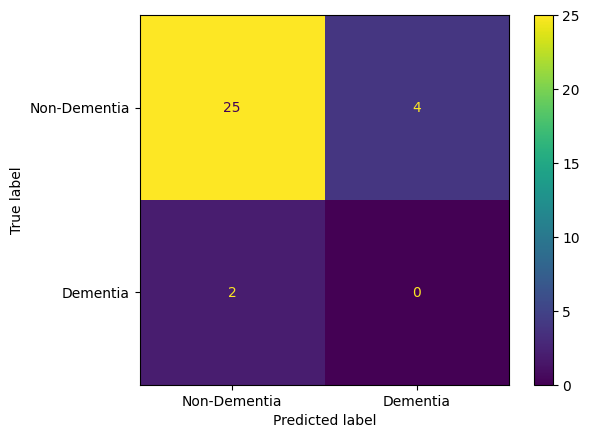

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  89
Epoch 0, Loss: 0.69683
Epoch 50, Loss: 0.00160
Epoch 100, Loss: 0.00011
Epoch 150, Loss: 0.00008
Epoch 200, Loss: 0.00006
Validating Stage 2 model on ensemble training set...
Setting batch size to  21
accuracy: 0.524
f1: 0.514
precision: 0.532
recall: 0.536


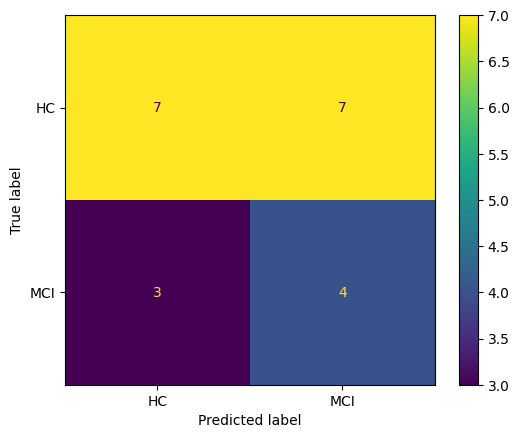

Validating Stage 2 model on meta model dev set...
Setting batch size to  25
accuracy: 0.680
f1: 0.667
precision: 0.677
recall: 0.666


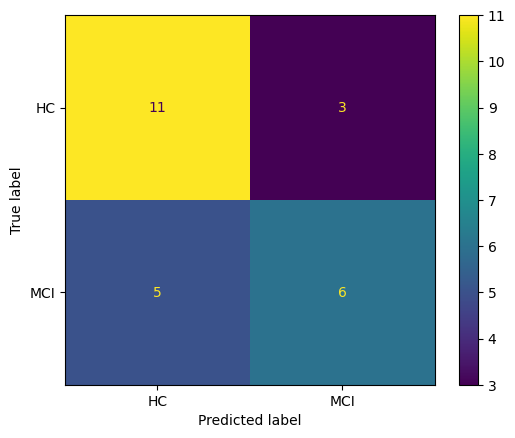

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.70      0.50      0.58        14
         MCI       0.36      0.44      0.40         9
    Dementia       0.00      0.00      0.00         3

   micro avg       0.48      0.42      0.45        26
   macro avg       0.35      0.31      0.33        26
weighted avg       0.50      0.42      0.45        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.69      0.69      0.69        16
         MCI       0.67      0.46      0.55        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.59      0.55      0.57        31
   macro avg       0.45      0.38      0.41        31
weighted avg       0.63      0.55      0.58        31

Fold 3:

        train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
        train set for meta model: 

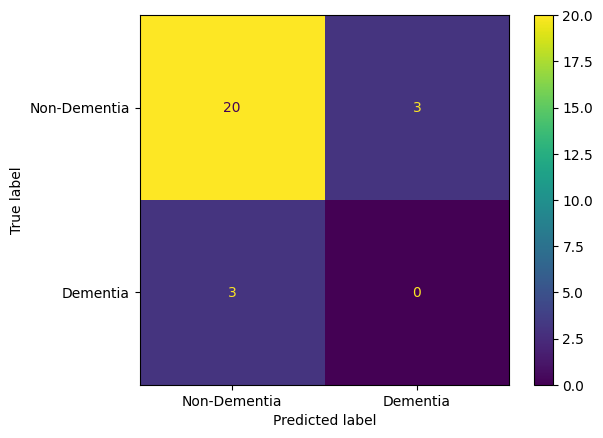

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.871
f1: 0.466
precision: 0.466
recall: 0.466


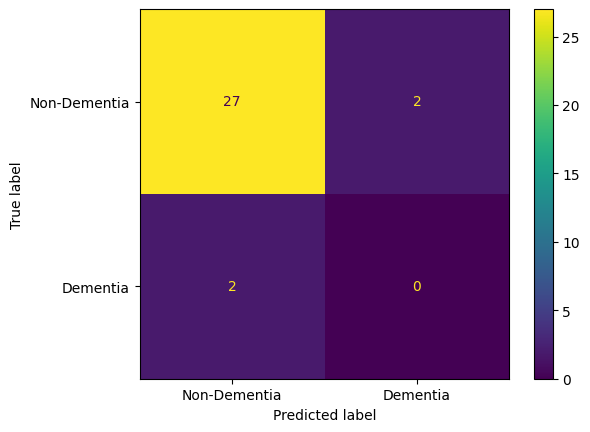

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  89
Epoch 0, Loss: 0.70755
Epoch 50, Loss: 0.33433
Epoch 100, Loss: 0.00879
Epoch 150, Loss: 0.00185
Epoch 200, Loss: 0.00090
Validating Stage 2 model on ensemble training set...
Setting batch size to  20
accuracy: 0.500
f1: 0.451
precision: 0.451
recall: 0.451


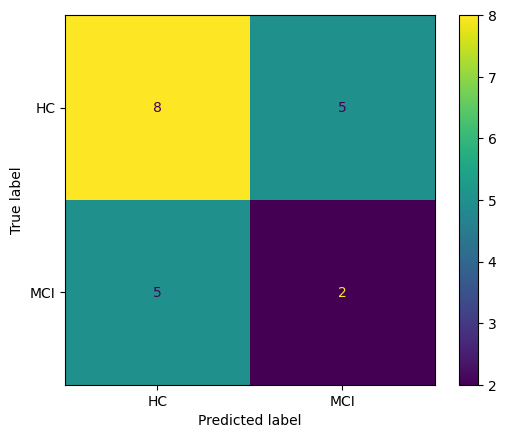

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.519
f1: 0.494
precision: 0.500
recall: 0.500


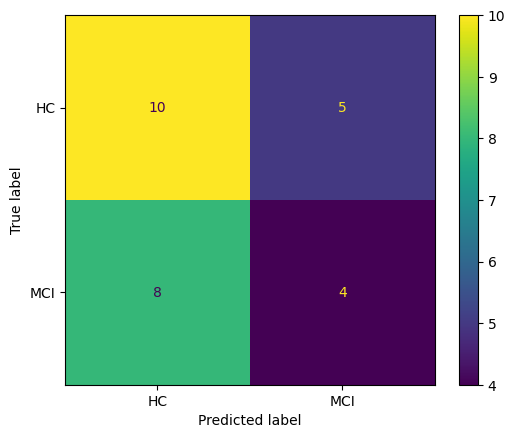

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.62      0.57      0.59        14
         MCI       0.29      0.22      0.25         9
    Dementia       0.00      0.00      0.00         3

   micro avg       0.43      0.38      0.41        26
   macro avg       0.30      0.26      0.28        26
weighted avg       0.43      0.38      0.41        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.56      0.62      0.59        16
         MCI       0.44      0.31      0.36        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.48      0.45      0.47        31
   macro avg       0.33      0.31      0.32        31
weighted avg       0.47      0.45      0.46        31

----------- Task: SFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.77211


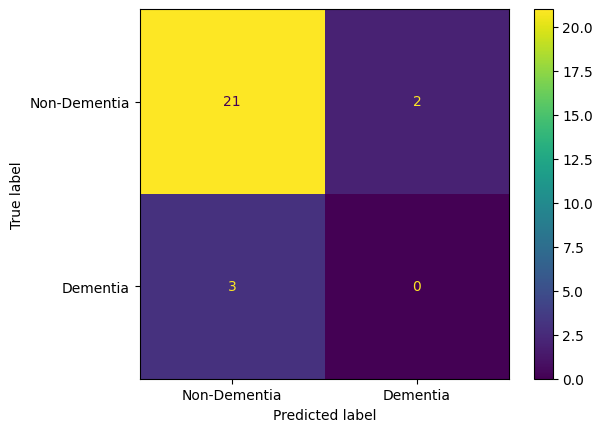

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.903
f1: 0.475
precision: 0.467
recall: 0.483


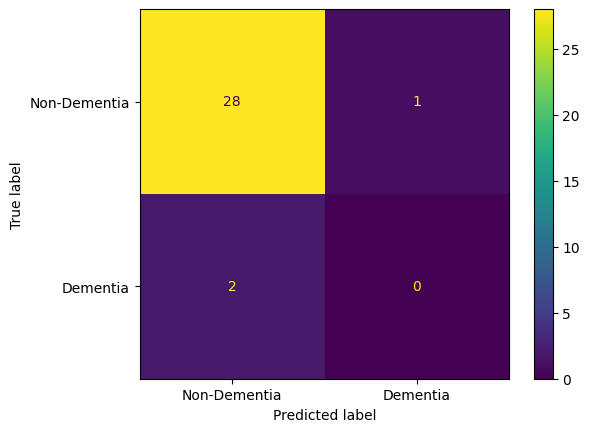

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  89
Epoch 0, Loss: 0.71442
Epoch 50, Loss: 0.07186
Epoch 100, Loss: 0.00070
Epoch 150, Loss: 0.00037
Epoch 200, Loss: 0.00024
Validating Stage 2 model on ensemble training set...
Setting batch size to  21
accuracy: 0.476
f1: 0.471
precision: 0.500
recall: 0.500


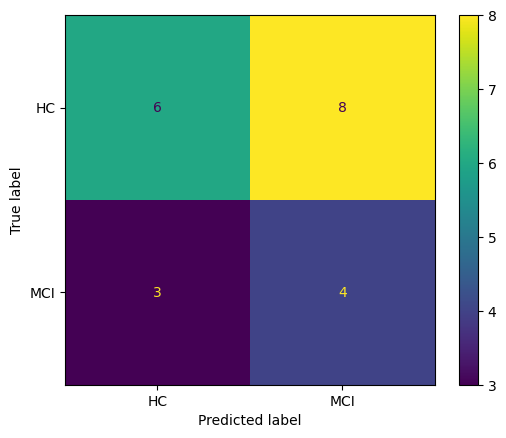

Validating Stage 2 model on meta model dev set...
Setting batch size to  28
accuracy: 0.464
f1: 0.464
precision: 0.464
recall: 0.464


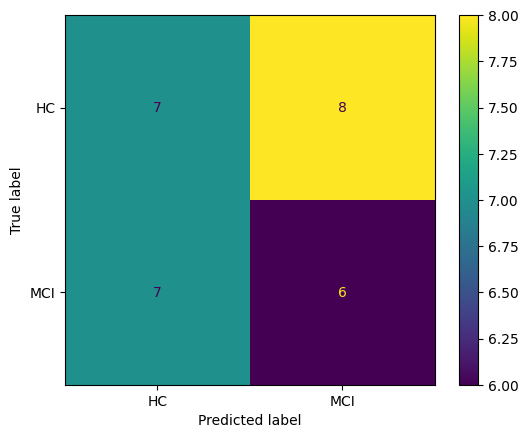

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.43      0.52        14
         MCI       0.33      0.44      0.38         9
    Dementia       0.00      0.00      0.00         3

   micro avg       0.43      0.38      0.41        26
   macro avg       0.33      0.29      0.30        26
weighted avg       0.47      0.38      0.41        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.44      0.47        16
         MCI       0.43      0.46      0.44        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.45      0.42      0.43        31
   macro avg       0.31      0.30      0.30        31
weighted avg       0.44      0.42      0.43        31

----------- Task: PFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.72853


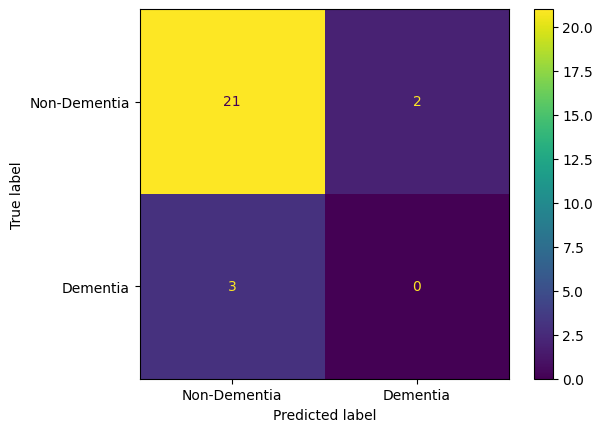

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.871
f1: 0.466
precision: 0.466
recall: 0.466


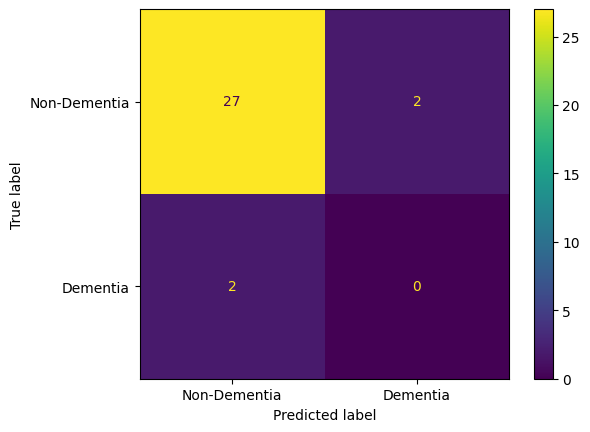

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  89
Epoch 0, Loss: 0.69514
Epoch 50, Loss: 0.00099
Epoch 100, Loss: 0.00009
Epoch 150, Loss: 0.00006
Epoch 200, Loss: 0.00005
Validating Stage 2 model on ensemble training set...
Setting batch size to  21
accuracy: 0.571
f1: 0.533
precision: 0.550
recall: 0.542


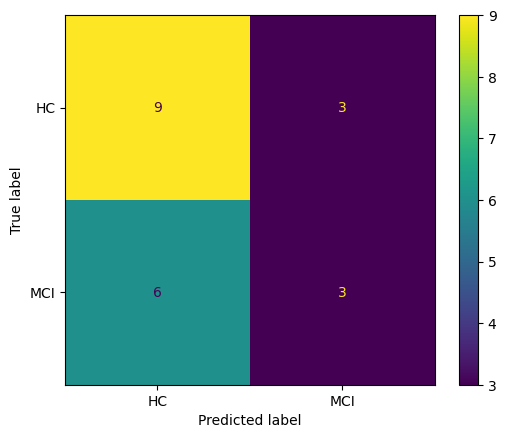

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.556
f1: 0.540
precision: 0.556
recall: 0.549


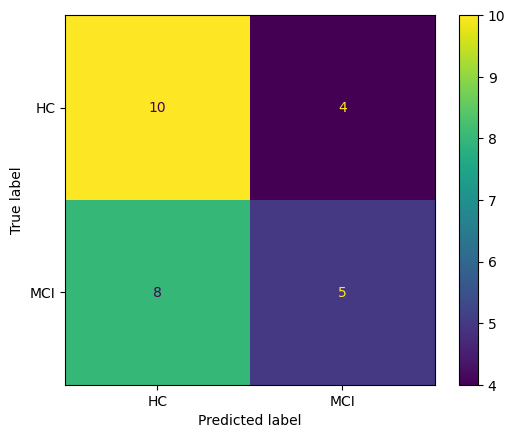

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.60      0.64      0.62        14
         MCI       0.50      0.33      0.40         9
    Dementia       0.00      0.00      0.00         3

   micro avg       0.52      0.46      0.49        26
   macro avg       0.37      0.33      0.34        26
weighted avg       0.50      0.46      0.47        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.56      0.62      0.59        16
         MCI       0.56      0.38      0.45        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.52      0.48      0.50        31
   macro avg       0.37      0.34      0.35        31
weighted avg       0.52      0.48      0.49        31

Fold 4:

        train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}),
        train set for meta model: 

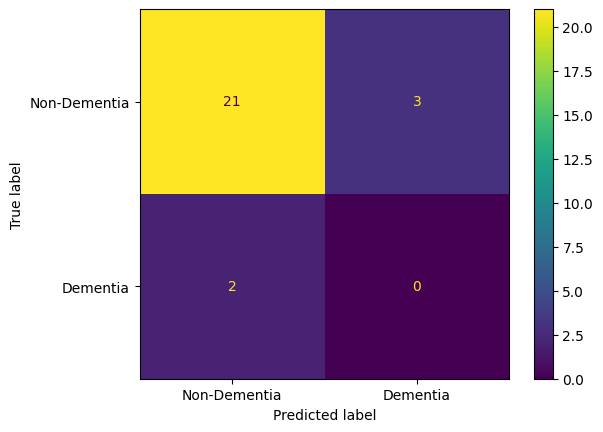

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.839
f1: 0.456
precision: 0.433
recall: 0.481


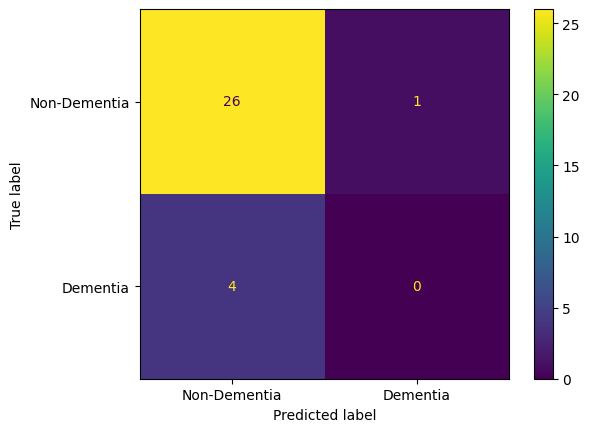

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.70905
Epoch 50, Loss: 0.37586
Epoch 100, Loss: 0.01715
Epoch 150, Loss: 0.00196
Epoch 200, Loss: 0.00094
Validating Stage 2 model on ensemble training set...
Setting batch size to  21
accuracy: 0.571
f1: 0.571
precision: 0.583
recall: 0.583


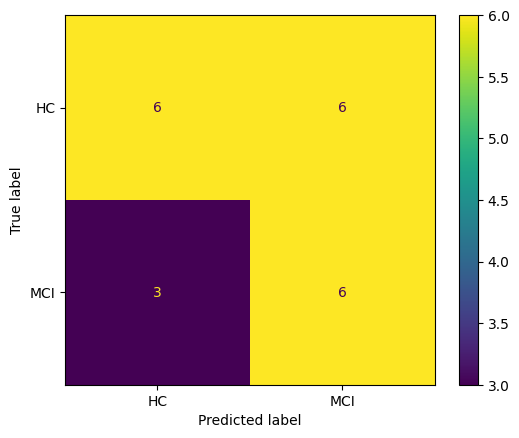

Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.615
f1: 0.549
precision: 0.610
recall: 0.570


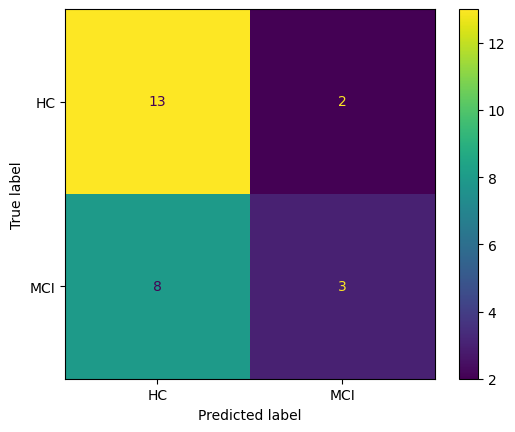

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.43      0.52        14
         MCI       0.50      0.60      0.55        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.50      0.46      0.48        26
   macro avg       0.39      0.34      0.36        26
weighted avg       0.55      0.46      0.49        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.62      0.87      0.72        15
         MCI       0.60      0.25      0.35        12
    Dementia       0.00      0.00      0.00         4

   micro avg       0.59      0.52      0.55        31
   macro avg       0.41      0.37      0.36        31
weighted avg       0.53      0.52      0.49        31

----------- Task: SFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.77069


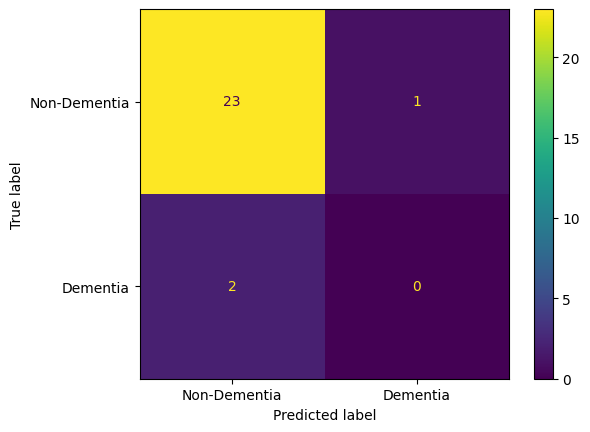

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.871
f1: 0.466
precision: 0.435
recall: 0.500


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


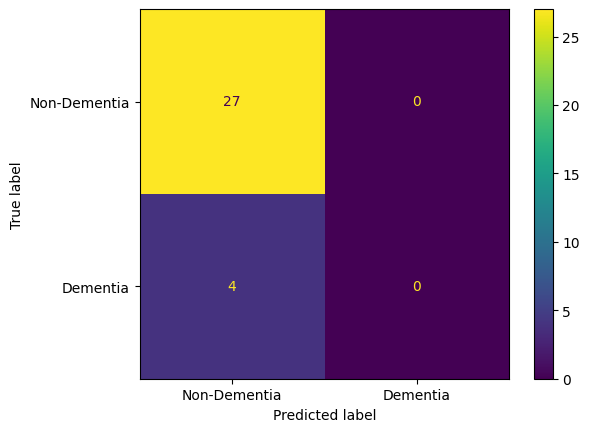

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.71062
Epoch 50, Loss: 0.04050
Epoch 100, Loss: 0.00048
Epoch 150, Loss: 0.00027
Epoch 200, Loss: 0.00019
Validating Stage 2 model on ensemble training set...
Setting batch size to  23
accuracy: 0.522
f1: 0.518
precision: 0.519
recall: 0.519


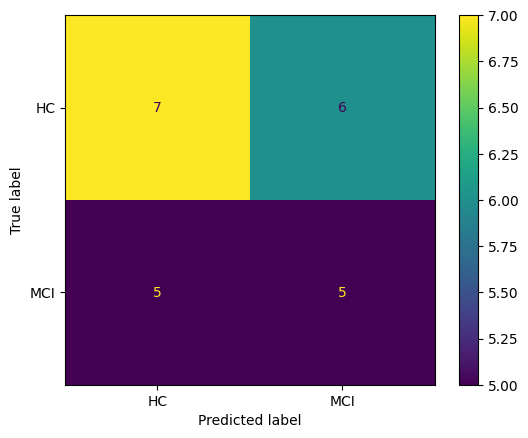

Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.593
f1: 0.583
precision: 0.585
recall: 0.583


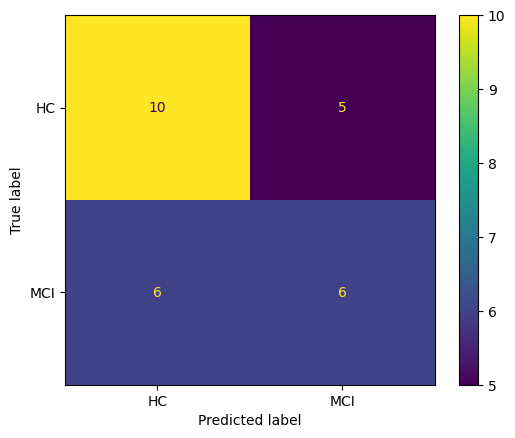

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.58      0.50      0.54        14
         MCI       0.45      0.50      0.48        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.50      0.46      0.48        26
   macro avg       0.35      0.33      0.34        26
weighted avg       0.49      0.46      0.47        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.62      0.67      0.65        15
         MCI       0.55      0.50      0.52        12
    Dementia       0.00      0.00      0.00         4

   micro avg       0.59      0.52      0.55        31
   macro avg       0.39      0.39      0.39        31
weighted avg       0.51      0.52      0.51        31

----------- Task: PFT -----------
Training base model for Dementia Classification...
Setting batch size to  100
Epoch 0, Loss: 0.72563


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 50, Loss: 0.00931
Epoch 100, Loss: 0.00014
Epoch 150, Loss: 0.00008
Epoch 200, Loss: 0.00006
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.846
f1: 0.458
precision: 0.458
recall: 0.458


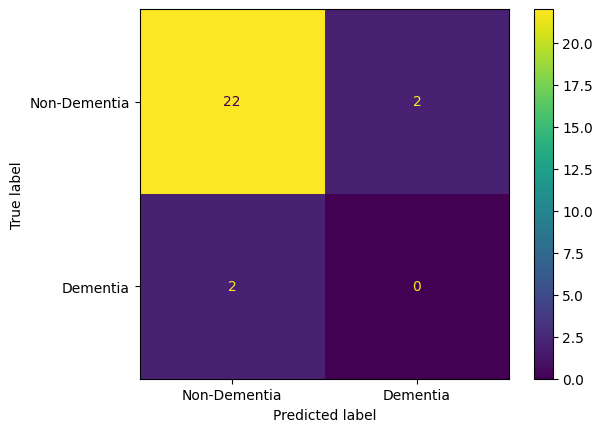

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.839
f1: 0.456
precision: 0.433
recall: 0.481


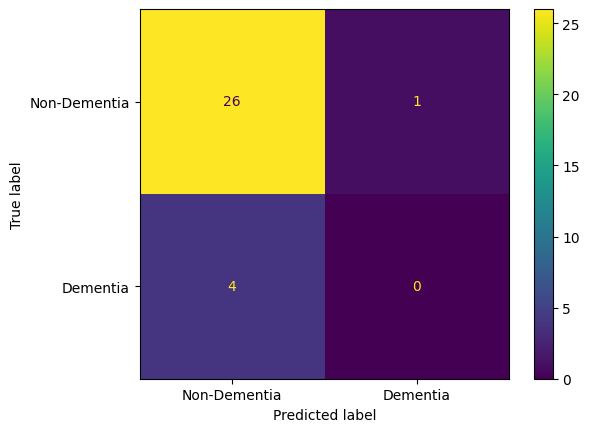

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  90
Epoch 0, Loss: 0.69448
Epoch 50, Loss: 0.00067
Epoch 100, Loss: 0.00008
Epoch 150, Loss: 0.00006
Epoch 200, Loss: 0.00005
Validating Stage 2 model on ensemble training set...
Setting batch size to  22
accuracy: 0.682
f1: 0.664
precision: 0.670
recall: 0.662


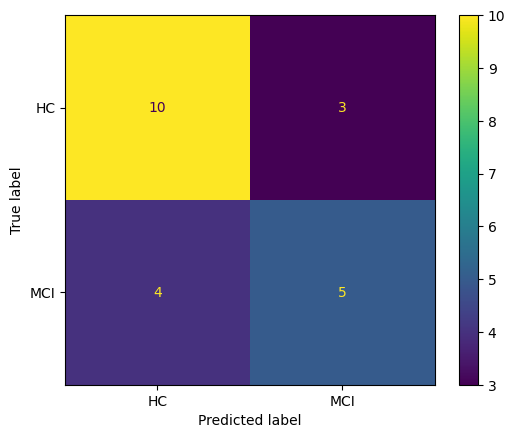

Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.462
f1: 0.458
precision: 0.458
recall: 0.458


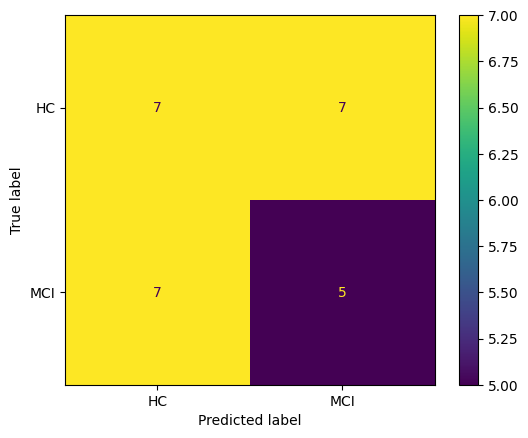

Overall Performance on Ensemble Training Dataset:
              precision    recall  f1-score   support

          HC       0.71      0.71      0.71        14
         MCI       0.62      0.50      0.56        10
    Dementia       0.00      0.00      0.00         2

   micro avg       0.62      0.58      0.60        26
   macro avg       0.45      0.40      0.42        26
weighted avg       0.62      0.58      0.60        26

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.47      0.48        15
         MCI       0.42      0.42      0.42        12
    Dementia       0.00      0.00      0.00         4

   micro avg       0.44      0.39      0.41        31
   macro avg       0.31      0.29      0.30        31
weighted avg       0.40      0.39      0.39        31

Mean F1 Score for CTD task (Stage 1 - Dementia vs. Non-Dementia): 0.456
Mean F1 Score for SFT task (Stage 1 - Dementia vs. Non-Dementia

In [26]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    "mode": "cascaded",  # or "non-cascaded"
    "tasks": ['CTD', 'SFT', 'PFT'],
    "num_folds": 5,
    "random_state": 42,
    "label_mapping_stage1": {0: 0, 1: 0, 2: 1},
    "label_mapping_stage2": {'HC': 0, 'MCI': 1},
    "label_mapping_non_cascaded": {'HC': 0, 'MCI': 1, 'Dementia': 2}
}


if config['mode'] == 'cascaded':
    metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
    metadata = metadata.sample(frac=1, random_state=config['random_state'], ignore_index=False)
    metadata['diagnosis_coded'] = metadata['diagnosis'].map(config['label_mapping_non_cascaded'])
    df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
    id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
    
    skf = StratifiedKFold(n_splits=config["num_folds"], shuffle=True, random_state=config['random_state'])
    F1scores_stage1 = defaultdict(list)
    F1scores_stage2 = defaultdict(list) 
    f1_overall_scores = defaultdict(list)

    for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
        print(f"Fold {fold_index}:")
        base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                            stratify=label_traindev[train_index],
                                                            test_size=0.2)
        
        print(f'''
        train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
        train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
        dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

        base_train_label_stage1 = base_train_label.map(config['label_mapping_stage1'])
        ensemble_train_label_stage1 = ensemble_train_label.map(config['label_mapping_stage1'])
        label_traindev_stage1_dev = label_traindev[dev_index].map(config['label_mapping_stage1'])

        base_train_label_stage2 = base_train_label[base_train_label != 2]
        ensemble_train_label_stage2 = ensemble_train_label[ensemble_train_label != 2]
        label_traindev_stage2_dev = label_traindev[dev_index][label_traindev[dev_index] != 2]

        base_train_id_stage2 = base_train_id[base_train_label != 2]
        ensemble_train_id_stage2 = ensemble_train_id[ensemble_train_label != 2]
        id_traindev_stage2_dev = id_traindev[dev_index][label_traindev[dev_index] != 2]

        class_weights_stage1 = calculate_class_weights(base_train_label_stage1)
        class_weights_stage2 = calculate_class_weights(base_train_label_stage2)

        for task in config['tasks']:
            print(f'----------- Task: {task} -----------')
            transcript_folder = os.path.join("transcripts_outputFiles", f"{task}_outputFiles")
            if not os.path.exists(transcript_folder):
                os.makedirs(transcript_folder)
            
            # Train Stage 1 model

            base_train_datalist_stage1 = get_datalist(base_train_id, base_train_label_stage1, transcript_folder)
            ensemble_train_datalist_stage1 = get_datalist(ensemble_train_id, ensemble_train_label_stage1, transcript_folder)
            ensemble_dev_datalist_stage1 = get_datalist(id_traindev[dev_index], label_traindev_stage1_dev[dev_index], transcript_folder)
            
            print('Training base model for Dementia Classification...')
            trained_gnn_stage1 = train_gnn(base_train_datalist_stage1)
            
            print('Validating on meta model train set...')
            task_logits_ensemble_training, task_pred_ensemble_training, results_dict, _ = eval_gnn(trained_gnn_stage1, ensemble_train_datalist_stage1, stage_labels= ['Non-Dementia', 'Dementia'], print_results=False)
            F1scores_stage1[task].append(results_dict["f1"])
            
            print('Validating on meta model dev set...')
            task_logits_ensemble_validation, task_pred_ensemble_validation, results_dict, _ = eval_gnn(trained_gnn_stage1, ensemble_dev_datalist_stage1, stage_labels= ['Non-Dementia', 'Dementia'], print_results=False)
            F1scores_stage1[task].append(results_dict["f1"])

            # Train Stage 2 model

            healthy_train_datalist = get_datalist(base_train_id_stage2, base_train_label_stage2, transcript_folder)

            print('Training base model for Healthy vs. MCI (Stage 2)...')
            class_weights_stage2 = calculate_class_weights(base_train_label_stage2)
            trained_gnn_stage2 = train_gnn(healthy_train_datalist)
            
            # Validate Stage 2 model on ensemble training set
            print('Validating Stage 2 model on ensemble training set...')
            predicted_healthy_ensemble_train_indices = [i for i, pred in enumerate(task_pred_ensemble_training) if pred == 0]
            predicted_healthy_ensemble_train_ids = []
            predicted_healthy_ensemble_train_labels = []

            dementia_misclassifications_train = 0

            for i in predicted_healthy_ensemble_train_indices:
                label = ensemble_train_label.iloc[i]
                if label != 2:
                    predicted_healthy_ensemble_train_ids.append(ensemble_train_id.iloc[i])
                    predicted_healthy_ensemble_train_labels.append(label)
                else:
                    dementia_misclassifications_train += 1

            predicted_healthy_ensemble_train_datalist = get_datalist(predicted_healthy_ensemble_train_ids, predicted_healthy_ensemble_train_labels, transcript_folder)

            _, task_pred_stage2_ensemble_train, results_dict, _ = eval_gnn(trained_gnn_stage2, predicted_healthy_ensemble_train_datalist, stage_labels=['HC', 'MCI'])
            F1scores_stage2[task].append(results_dict["f1"])

            # Validate Stage 2 model on ensemble validation set

            print('Validating Stage 2 model on meta model dev set...')
            predicted_healthy_dev_indices = [i for i, pred in enumerate(task_pred_ensemble_validation) if pred == 0]
           
            predicted_healthy_dev_ids = []
            predicted_healthy_dev_labels = []

            dementia_misclassifications_dev = 0

            for i in predicted_healthy_dev_indices:
                label = label_traindev[dev_index].iloc[i]
                if label != 2:
                    predicted_healthy_dev_ids.append(id_traindev[dev_index].iloc[i])
                    predicted_healthy_dev_labels.append(label)
                else:
                    dementia_misclassifications_dev += 1

            predicted_healthy_dev_datalist = get_datalist(predicted_healthy_dev_ids, predicted_healthy_dev_labels, transcript_folder)

            _, task_pred_stage2_dev, results_dict, _ = eval_gnn(trained_gnn_stage2, predicted_healthy_dev_datalist, stage_labels=['HC', 'MCI'])
            F1scores_stage2[task].append(results_dict["f1"])

            # Calculate overall performance on ensemble training set
            combined_predictions_ensemble_train = []

            # Ensure healthy_ensemble_train_ids and task_pred_stage2_ensemble_train are lists
            predicted_healthy_ensemble_train_ids = predicted_healthy_ensemble_train_ids if isinstance(predicted_healthy_ensemble_train_ids, list) else healthy_ensemble_train_ids.tolist()
            task_pred_stage2_ensemble_train = task_pred_stage2_ensemble_train if isinstance(task_pred_stage2_ensemble_train, list) else task_pred_stage2_ensemble_train.tolist()

            stage2_predictions_dict = dict(zip(predicted_healthy_ensemble_train_ids, task_pred_stage2_ensemble_train))

            for i, id_value in enumerate(ensemble_train_id):
                if task_pred_ensemble_training[i] == 0:  
                    if id_value in stage2_predictions_dict:
                        if stage2_predictions_dict[id_value] == 0:
                            combined_predictions_ensemble_train.append('HC')
                        else:
                            combined_predictions_ensemble_train.append('MCI')
                    else:
                        combined_predictions_ensemble_train.append('Unknown_Non_Dementia')
                else:  # Stage 1 predicted Dementia
                    combined_predictions_ensemble_train.append('Dementia')

            actual_labels_ensemble_train = ensemble_train_label.map({0: 'HC', 1: 'MCI', 2: 'Dementia'})

            print('Overall Performance on Ensemble Training Dataset:')
            print(classification_report(actual_labels_ensemble_train, combined_predictions_ensemble_train, labels=['HC', 'MCI', 'Dementia'], target_names=['HC', 'MCI', 'Dementia']))

            report = classification_report(actual_labels_ensemble_train, combined_predictions_ensemble_train, labels=['HC', 'MCI', 'Dementia'], target_names=['HC', 'MCI', 'Dementia'], output_dict=True)
            
            f1_overall_scores[task].append(report['macro avg']['f1-score'])

            # Calculate overall performance on ensemble development set

            combined_predictions_ensemble_dev = []

            predicted_healthy_dev_ids = predicted_healthy_dev_ids if isinstance(predicted_healthy_dev_ids, list) else predicted_healthy_dev_ids.tolist()
            task_pred_stage2_dev = task_pred_stage2_dev if isinstance(task_pred_stage2_dev, list) else task_pred_stage2_dev.tolist()

            stage2_predictions_dev_dict = dict(zip(predicted_healthy_dev_ids, task_pred_stage2_dev))

            for i, id_value in enumerate(id_traindev[dev_index]):
                if task_pred_ensemble_validation[i] == 0: 
                    if id_value in stage2_predictions_dev_dict:
                        if stage2_predictions_dev_dict[id_value] == 0:
                            combined_predictions_ensemble_dev.append('HC')
                        else:
                            combined_predictions_ensemble_dev.append('MCI')
                    else:
                        combined_predictions_ensemble_dev.append('Unknown_Non_Dementia')
                else:  # Stage 1 predicted Dementia
                    combined_predictions_ensemble_dev.append('Dementia')

            actual_labels_ensemble_dev = label_traindev[dev_index].map({0: 'HC', 1: 'MCI', 2: 'Dementia'})

            print('Overall Performance on Ensemble Development Dataset:')
            print(classification_report(actual_labels_ensemble_dev, combined_predictions_ensemble_dev, labels=['HC', 'MCI', 'Dementia'], target_names=['HC', 'MCI', 'Dementia']))
            
            report_dev = classification_report(actual_labels_ensemble_dev, combined_predictions_ensemble_dev, labels=['HC', 'MCI', 'Dementia'], target_names=['HC', 'MCI', 'Dementia'], output_dict=True)
            
            f1_overall_scores[task].append(report_dev['macro avg']['f1-score'])



            
    mean_f1_stage1 = {}
    mean_f1_stage2 = {}
    mean_f1_overall = {}

    for key in F1scores_stage1.keys():
        mean_f1_stage1[key] = sum(F1scores_stage1[key]) / len(F1scores_stage1[key])
        mean_f1_stage2[key] = sum(F1scores_stage2[key]) / len(F1scores_stage2[key])
        mean_f1_overall[key] = sum(f1_overall_scores[key]) / len(f1_overall_scores[key])

    for key, values in mean_f1_stage1.items():
        print(f"Mean F1 Score for {key} task (Stage 1 - Dementia vs. Non-Dementia): {values:.3f}")

    for key, values in mean_f1_stage2.items():
        print(f"Mean F1 Score for {key} task (Stage 2 - Healthy vs. MCI): {values:.3f}") 

    for key, values in mean_f1_overall.items():
        print(f"Mean F1 Score for {key} task (Overall): {values:.3f}")       